In [1]:
# Multiplicative scaling constants
B_b   = 1e1
b_B   = 1/B_b
G_1   = 1e9
one_G = 1/G_1
G_K   = 1e6
K_G   = 1/G_K
G_M   = 1e3
M_G   = 1/G_M
K_1   = 1e3
one_K = 1/K_1
M_1   = 1e6
one_M = 1/M_1
m_1   = 1e-3
one_m = 1/m_1
m_u   = 1e3 
u_m   = 1/m_u
u_1   = 1e-6
one_u = 1/u_1
n_1   = 1e-9
one_n = 1/n_1
n_m   = 1e-6
m_n   = 1/n_m
n_u   = 1e-3
u_n   = 1/n_u

sz1K  = 1024
sz1M  = sz1K*sz1K
sz1G  = sz1M*sz1K


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from datetime import datetime

sns.set(style="darkgrid")

# Compute statistical moments: mean, std, skewness, kurtosis
def compute_moments(series):
    values = series #.dropna()
    return {
        'count': len(values),
        'mean': values.mean(),
        'std': values.std(),
        'skew': skew(values),
        'kurtosis': kurtosis(values)
    }

# Load the log file into a list of lines
def load_log_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines if line.strip()]


In [3]:
pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yaml
import pandas as pd
from pandas import json_normalize

# Load YAML
with open("cpu_emu.yaml", "r") as f:
    data = yaml.safe_load(f)

# Flatten into a DataFrame
prmtrs_df = json_normalize(data, sep=".")
print(prmtrs_df.T)  # transpose to make it easier to read

cmp_ltnc_nS_B   = float(prmtrs_df['latency'].iloc[0])
output_size_GB  = float(prmtrs_df['output_size'].iloc[0])
frame_cnt       = int(prmtrs_df['frame_cnt'].iloc[0])


                       0
latency              500
mem_footprint       0.05
output_size     0.000057
sbscrptn_ip    127.0.0.1
sub_prt             7000
pub_prt             7001
sleep                  0
threads                1
verbose                1
terminal               0
frame_cnt           1000


In [5]:
prmtrs_df

latency  mem_footprint  output_size sbscrptn_ip  sub_prt  pub_prt  sleep  \
0      500           0.05     0.000057   127.0.0.1     7000     7001      0   

   threads  verbose  terminal  frame_cnt  
0        1        1         0       1000

In [6]:
#Frames actually processed by components
prcsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "cmp_ltnc_uS": pd.Series(dtype=float),
    "ntwrk_lt_uS": pd.Series(dtype=float),
    "snt_uS":      pd.Series(dtype=float),
    "done_uS":     pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Frames that components were not ready to receive
drpmsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "lstDone_uS":  pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Data on all sent frames - component 0 is source
sentFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "snt_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float)
}) 

#set of all frame numbers from sender
all_frm_set = set(range(1, frame_cnt + 1))   # range is exclusive at the end, so add 1 for inclusive


In [7]:
# Replace this with the actual path to your log file
log_path = "emu_log.txt" #"emu_log.txt"

# Load and inspect
lines = load_log_file(log_path)
print(f"Loaded {len(lines)} lines from the log.")


Loaded 158051 lines from the log.


In [8]:
# Extract lines with frame send information for sender
frame_rate_lines = [line for line in lines if "[emulate_stream:] Sending frame size" in line]
min_uS = 1e30
fs_value = pd.NA
ts_value = pd.NA
fn_match = pd.NA
# Parse frame rate values from lines
#First determine 'min_uS' value to achieve zero offset clock
for line in frame_rate_lines:
    ts_match = re.search(r"^([\d.]+)", line)
    if ts_match:
        ts_value = float(ts_match.group(1) if ts_match else None)
        min_uS = min(ts_value, min_uS)
    else:
        print("No ts_match")

for line in frame_rate_lines:
    fs_match = re.search(r"Sending frame size = ([\d.]+)", line)
    if fs_match:
        fs_value = B_b*float(fs_match.group(1))
    else:
        print("No fs_match")
    ts_match = re.search(r"^([\d.]+)", line)
    if ts_match:
        ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
    else:
        print("No ts_match")
    fn_match = re.search(r"\(([\d.]+)\)", line)
    if fn_match:
        fn_value = float(fn_match.group(1) if fn_match else None)
    else:
        print("No fn_match")
    row = (int(0),float(ts_value),int(fn_value),float(fs_value))
    sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)


In [9]:
min_uS

1756502449988691.0

In [10]:
#determine emulation port range
#port_lines = [line for line in lines if "Connecting to receiver tcp" in line]
cmpnt_ids = []
port_lines = [line for line in lines if "Subscribing to" in line]
#port_lines
for line in port_lines:
    match = re.search(r"cpu_emu ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        cmpnt_ids.append(int(value))
    else:
        print("No match in port line:", line)
cmpnt_ids


[6000, 6001, 6002, 6003, 6004, 6005, 6006]

In [11]:
cmpnt_ids

[6000, 6001, 6002, 6003, 6004, 6005, 6006]

In [12]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Extract lines with frame send information all components
    fs_value = pd.NA
    ts_value = pd.NA
    fn_match = pd.NA
    frame_send_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:  Sending frame size" in line]    
    for line in frame_send_lines:
        fs_match = re.search(r"Sending frame size = ([\d.]+)", line)
        if fs_match:
            fs_value = B_b*float(fs_match.group(1))
        else:
            print("No fs_match")
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"\(([\d.]+)\)", line)
        if fn_match:
            fn_value = int(fn_match.group(1) if fn_match else None)
        else:
            print("No fn_match")
        row = (int(index+1),float(ts_value),int(fn_value),float(fs_value))
        sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)


In [13]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Extract lines with frame rcv information all components
    ts_value = pd.NA
    fn_match = pd.NA
    frame_rcv_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:  recd " in line]
    for line in frame_rcv_lines:
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"recd ([\d.]+)", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        # New row with only some columns filled
        row = pd.DataFrame([{"component": int(index+1), "frm_nm": fn_value, "rcd_uS": ts_value}])        
        # Concatenate
        prcsdFrms_df = pd.concat([prcsdFrms_df, row], ignore_index=True)

In [14]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Extract lines with frame done information all components
    ts_value = pd.NA
    fn_match = pd.NA
    frame_rcv_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:  done" in line]
    for line in frame_rcv_lines:
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"done \(([\d.]+)\)", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        # New row with only some columns filled
        row = pd.DataFrame([{"component": int(index+1), "frm_nm": fn_value, "done_uS": ts_value}])        
        # update done_uS
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "done_uS"] = ts_value


In [15]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Extract lines with frame size information all components
    fs_value = pd.NA
    fn_match = pd.NA
    frame_sz_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:" in line and "actual" in line]
    for line in frame_sz_lines:
        fn_match = re.search(r"\(([\d.]+)\)$", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        fs_match = re.search(r"\(actual\) ([\d.]+)", line)
        if fs_match:
            fs_value = B_b*float(fs_match.group(1))
        else:
            print("No fs_match")
        # update frm_sz_b
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "frm_sz_b"] = fs_value
        # update snt_uS by reteiving value from sentFrms_df
        if cmpnt_id != max(cmpnt_ids): #not the last or sink component
            snt_uS = sentFrms_df.loc[(sentFrms_df["component"] == int(index+1)) & (sentFrms_df["frm_nm"] == fn_value), "snt_uS"].iloc[0]
            prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "snt_uS"] = snt_uS

In [16]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Extract lines with frame size information all components
    fs_value = pd.NA
    fn_match = pd.NA
    frame_sz_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]:" in line and "Measured latencies" in line]
    for line in frame_sz_lines:
        fn_match = re.search(r"\(([\d.]+)\)$", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        cl_match = re.search(r"last_cmp_lat_uS = ([\d.]+)", line)
        if cl_match:
            cl_value = float(cl_match.group(1))
        else:
            print("No cl_match")
        nl_match = re.search(r"last_nw_lat_uS = ([\d.]+)", line)
        if nl_match:
            nl_value = float(nl_match.group(1))
        else:
            print("No cl_match")
        # update done_uS
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "cmp_ltnc_uS"] = cl_value
        prcsdFrms_df.loc[(prcsdFrms_df["component"] == int(index+1)) & (prcsdFrms_df["frm_nm"] == fn_value), "ntwrk_lt_uS"] = nl_value


In [17]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Extract lines with frame rcv information all components
    fs_value = pd.NA
    ts_value = pd.NA
    fn_match = pd.NA
    frame_drp_lines = [line for line in lines if f"[cpu_emu {cmpnt_id}]" in line and "dropped" in line]
    for line in frame_drp_lines:
        ts_match = re.search(r"^([\d.]+)", line)
        if ts_match:
            ts_value = float(ts_match.group(1) if ts_match else None) - min_uS
        else:
            print("No ts_match")
        fn_match = re.search(r"\(([\d.]+)\)", line)
        if fn_match:
            fn_value = int(fn_match.group(1))
        else:
            print("No fn_match")
        # New row with only some columns filled
        row = pd.DataFrame([{"component": int(index+1), "frm_nm": fn_value, "rcd_uS": ts_value}])        
        # Concatenate
        drpmsdFrms_df = pd.concat([drpmsdFrms_df, row], ignore_index=True)

In [18]:
drpmsdFrms_df

Empty DataFrame
Columns: [component, rcd_uS, frm_nm, frm_sz_b, lstDone_uS]
Index: []

Component 0 Send Delta Statistics:
count: 999.000
mean: 15.073
std: 2.002
skew: 0.281
kurtosis: -0.220


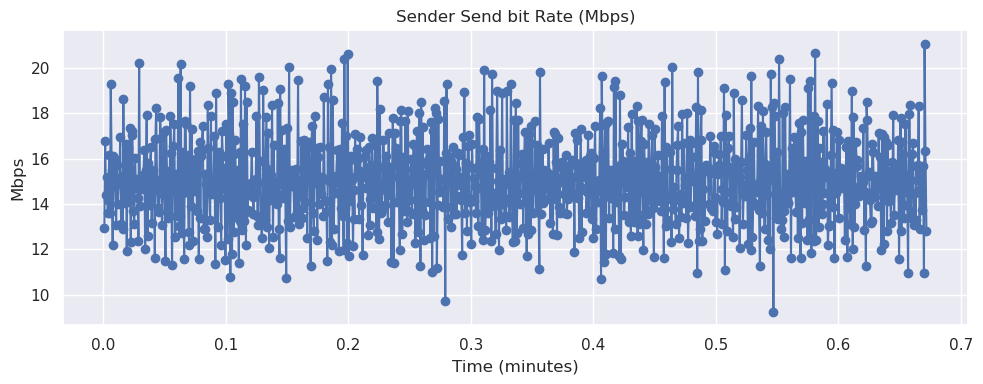

In [19]:
#Plot for Sender = component 0

sim_tm_uS = sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"][1:].reset_index(drop=True)
dts_S = u_1*(sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"][1:].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == 0, "snt_uS"][:-1].reset_index(drop=True))
szs_b = sentFrms_df.loc[sentFrms_df["component"] == 0, "frm_sz_b"][1:].reset_index(drop=True)

btRt_Mbps = one_M*szs_b/dts_S
# Display statistics
btRt_stats_Mbps = compute_moments(btRt_Mbps)

print(f"Component {0} Send Delta Statistics:")
for k, v in btRt_stats_Mbps.items():
    print(f"{k}: {v:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
plt.title(f"Sender Send bit Rate (Mbps)")
plt.xlabel('Time (minutes)')
plt.ylabel('Mbps')
#plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
cmpnt_ids

[6000, 6001, 6002, 6003, 6004, 6005, 6006]

In [21]:
sentFrms_df

component      snt_uS  frm_nm  frm_sz_b
0             0         0.0       1  656020.0
1             0     44128.0       2  571910.0
2             0     82389.0       3  641840.0
3             0    125307.0       4  617790.0
4             0    166618.0       5  628080.0
...         ...         ...     ...       ...
6995          6  40354253.0     996  646420.0
6996          6  40389748.0     997  620490.0
6997          6  40419997.0     998  644640.0
6998          6  40465477.0     999  594550.0
6999          6  40508626.0    1000  616910.0

[7000 rows x 4 columns]

In [22]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    print(index, cmpnt_id)

0 6000
1 6001
2 6002
3 6003
4 6004
5 6005
6 6006


In [23]:
for index, cmpnt_id in enumerate(cmpnt_ids[:-1]):
    print(index, cmpnt_id)

0 6000
1 6001
2 6002
3 6003
4 6004
5 6005


Component 1 Send Bit Rate Statistics:
count: 999.000
mean: 15.364
std: 2.002
skew: 0.329
kurtosis: 0.146


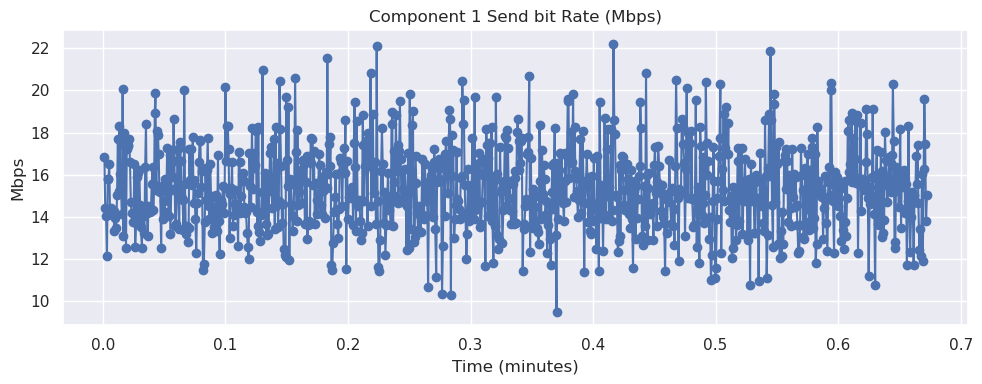

Component 2 Send Bit Rate Statistics:
count: 999.000
mean: 15.510
std: 2.699
skew: 0.607
kurtosis: 0.439


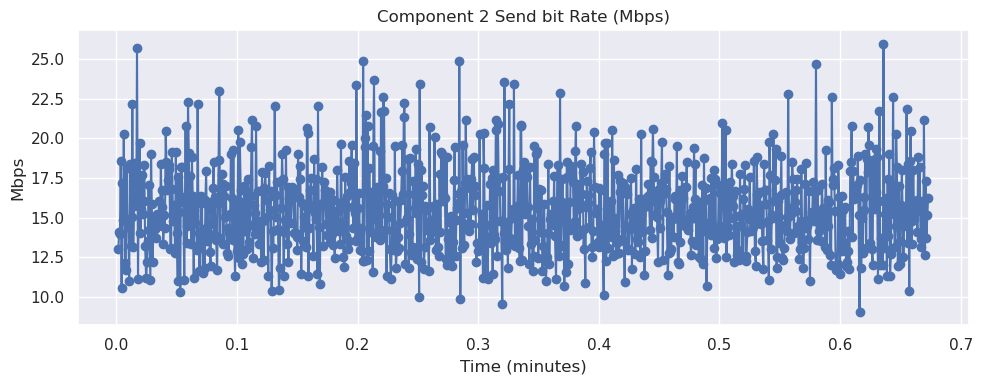

Component 3 Send Bit Rate Statistics:
count: 999.000
mean: 15.660
std: 3.074
skew: 0.624
kurtosis: 0.360


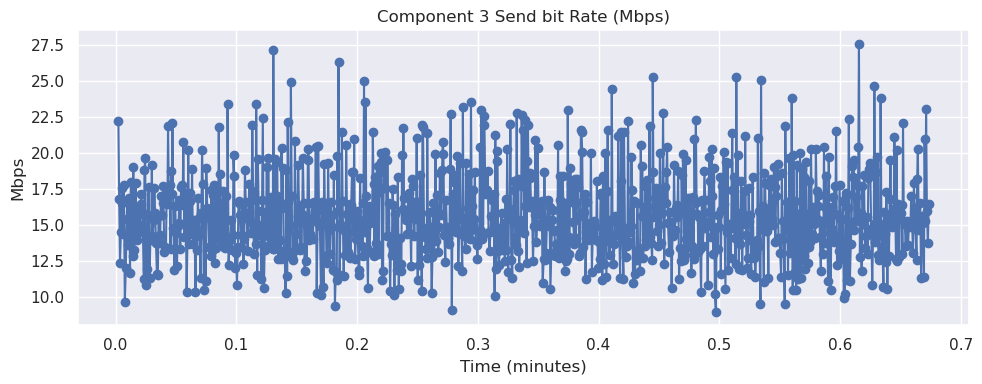

Component 4 Send Bit Rate Statistics:
count: 999.000
mean: 15.760
std: 3.350
skew: 0.613
kurtosis: 0.263


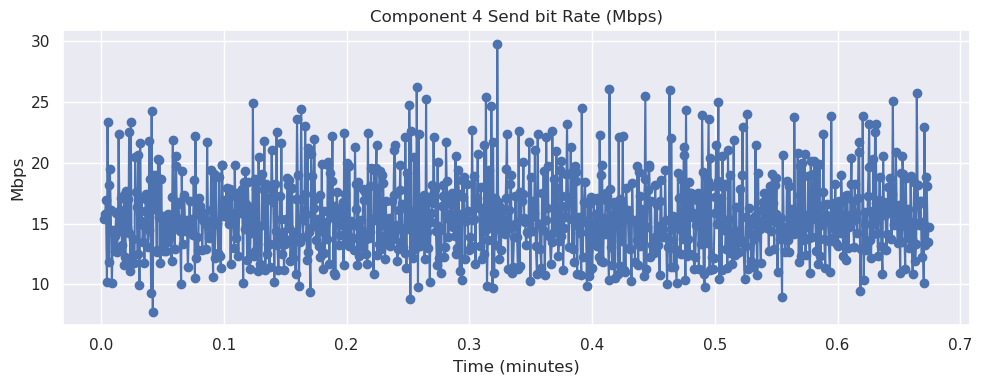

Component 5 Send Bit Rate Statistics:
count: 999.000
mean: 15.729
std: 3.505
skew: 0.549
kurtosis: -0.004


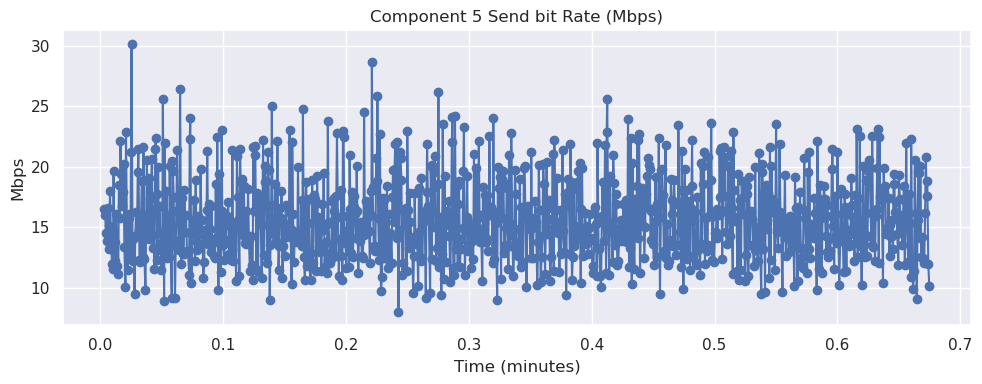

Component 6 Send Bit Rate Statistics:
count: 999.000
mean: 15.924
std: 3.539
skew: 0.448
kurtosis: -0.033


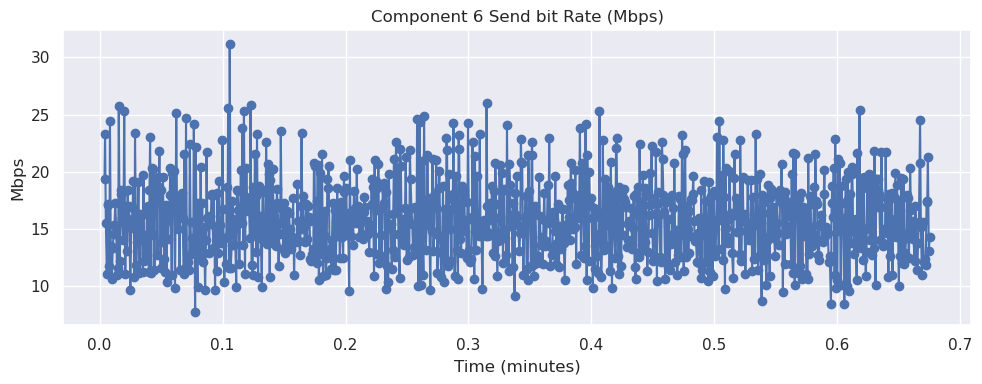

In [24]:
#Plot for Components - last component does not send
for index, cmpnt_id in enumerate(cmpnt_ids[:-1]):

    sim_tm_uS = sentFrms_df.loc[sentFrms_df["component"] == index+1, "snt_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(sentFrms_df.loc[sentFrms_df["component"] == index+1, "snt_uS"][1:].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == index+1, "snt_uS"][:-1].reset_index(drop=True))
    szs_b = sentFrms_df.loc[sentFrms_df["component"] == index+1, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {index+1} Send Bit Rate Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Send bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Frame Rate Statistics:
count: 999.000
mean: 25.015
std: 2.460
skew: 0.517
kurtosis: 0.254


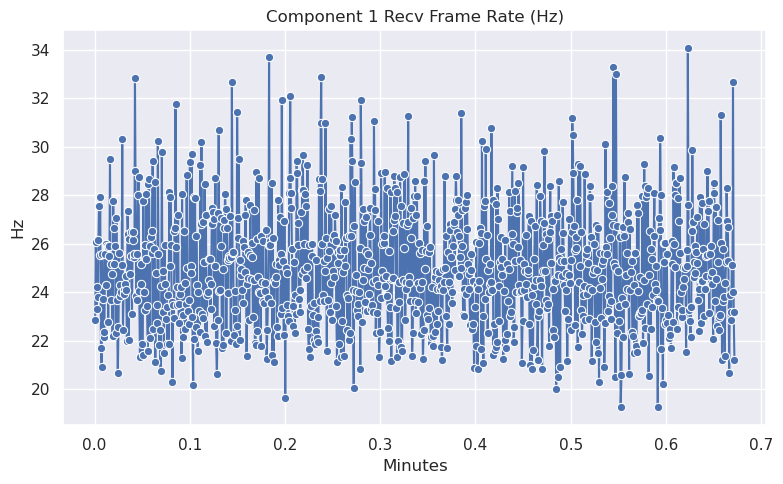

Component 2 Frame Rate Statistics:
count: 999.000
mean: 24.934
std: 1.963
skew: 0.439
kurtosis: 0.057


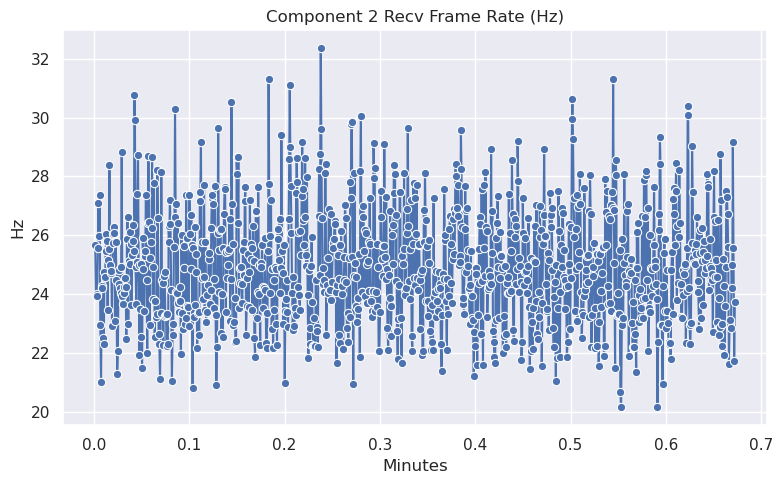

Component 3 Frame Rate Statistics:
count: 999.000
mean: 25.176
std: 3.208
skew: 0.506
kurtosis: 0.101


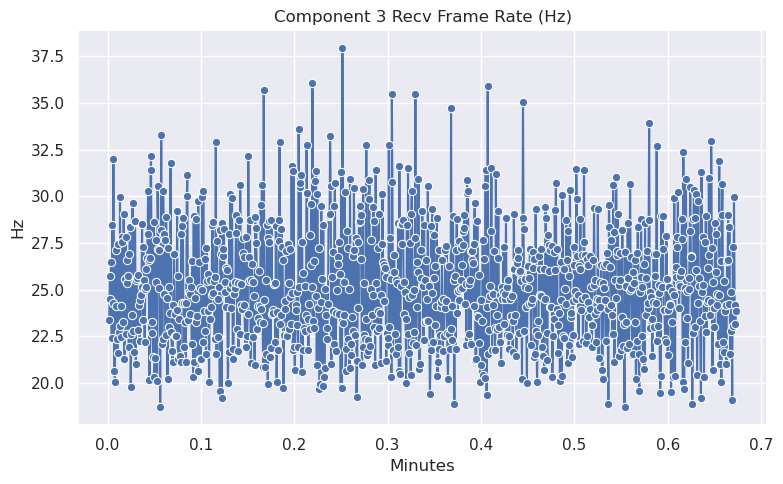

Component 4 Frame Rate Statistics:
count: 999.000
mean: 25.333
std: 3.738
skew: 0.256
kurtosis: -0.519


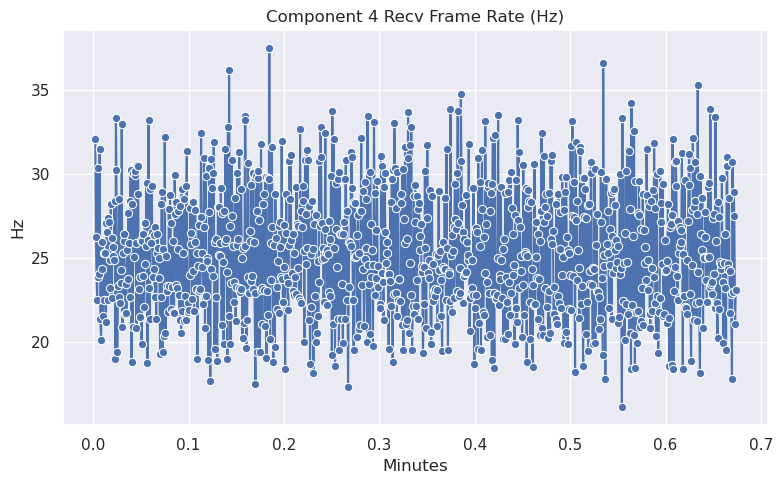

Component 5 Frame Rate Statistics:
count: 999.000
mean: 25.444
std: 4.110
skew: 0.244
kurtosis: -0.461


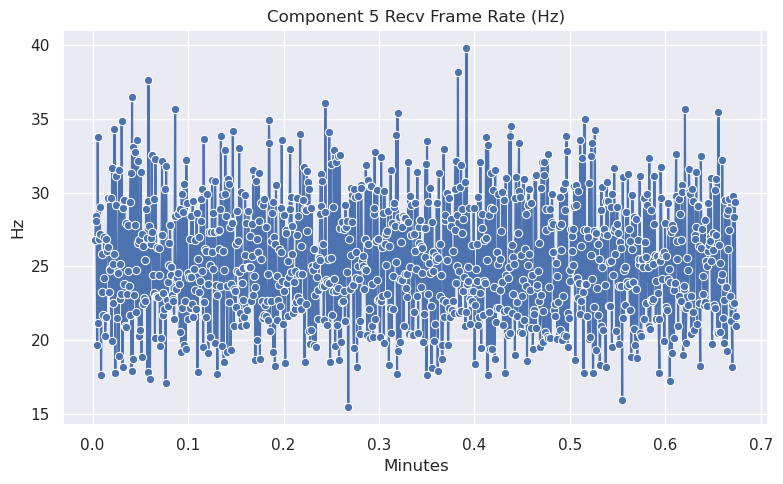

Component 6 Frame Rate Statistics:
count: 999.000
mean: 25.521
std: 4.286
skew: 0.046
kurtosis: -0.752


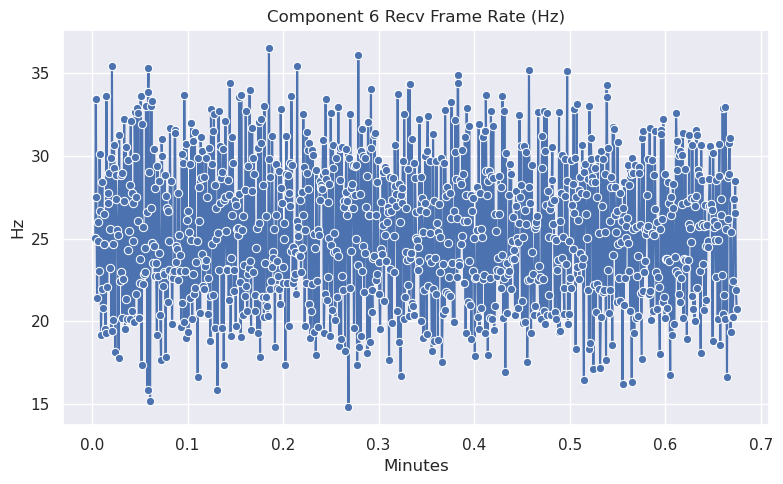

Component 7 Frame Rate Statistics:
count: 999.000
mean: 25.618
std: 4.487
skew: -0.080
kurtosis: -0.823


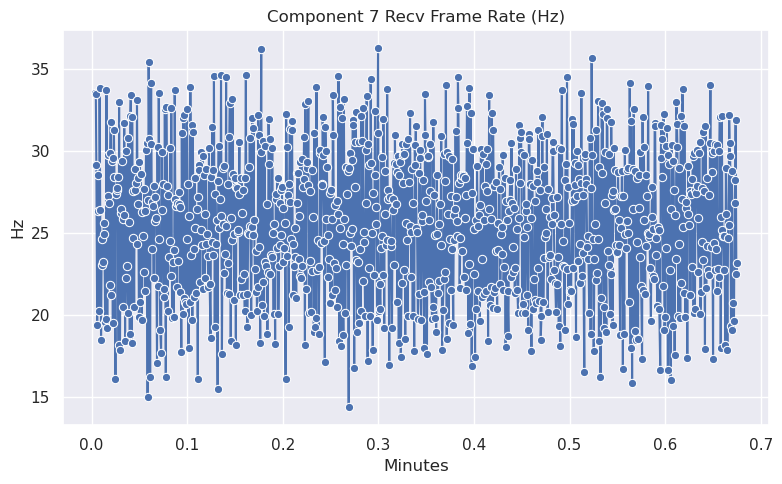

In [25]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    dt_S_arr           = np.diff(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"])
    frame_rates_Hz_arr = 1/dt_S_arr

    # Display statistics
    frame_rate_stats = compute_moments(frame_rates_Hz_arr)

    print(f"Component {index+1} Frame Rate Statistics:")
    for k, v in frame_rate_stats.items():
        print(f"{k}: {v:.3f}")

    # Plot Frame Rate
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))

    timestamps_S_arr = u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][1:]

    sns.lineplot(x=timestamps_S_arr/60.0, y=frame_rates_Hz_arr, marker="o")       # line + markers
    # —or using pure matplotlib:
    # plt.plot(x, y, marker='o', linestyle='-')

    plt.title(f"Component {index+1} Recv Frame Rate (Hz)")
    plt.xlabel("Minutes")
    plt.ylabel("Hz")
    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # plt.title(f"Component {index} Recv Frame Delta (uS)")
    # plt.xlabel("Minutes")
    # plt.ylabel("mS")
    # plt.tight_layout()
    # plt.show()


Component 1 Recv Delta Statistics:
count: 999.000
mean: 9.770
std: 0.972
skew: 0.015
kurtosis: -0.262


<Figure size 800x500 with 0 Axes>

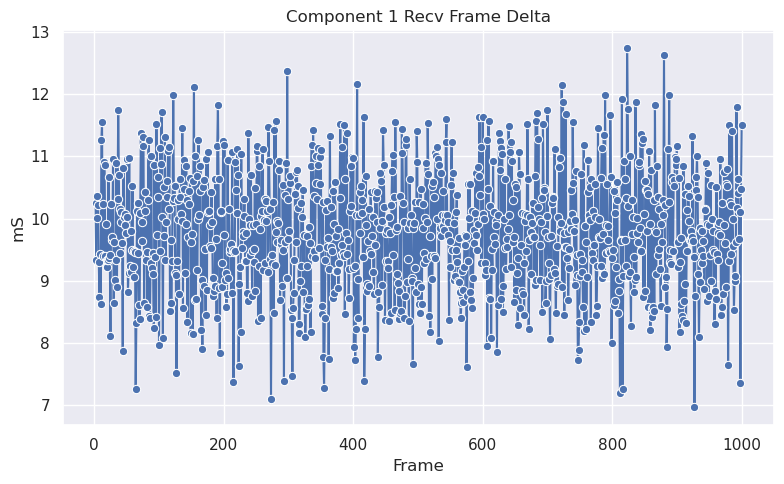

Component 2 Recv Delta Statistics:
count: 999.000
mean: 9.108
std: 4.367
skew: 0.126
kurtosis: -0.478


<Figure size 800x500 with 0 Axes>

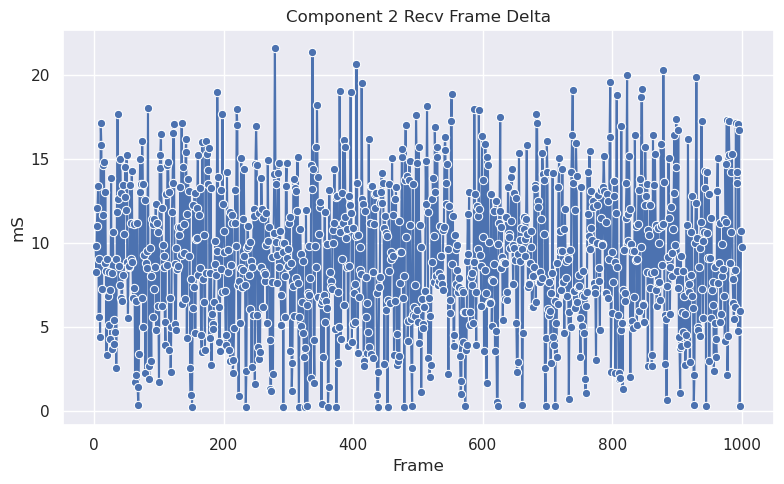

Component 3 Recv Delta Statistics:
count: 999.000
mean: 9.234
std: 5.727
skew: 0.247
kurtosis: -0.610


<Figure size 800x500 with 0 Axes>

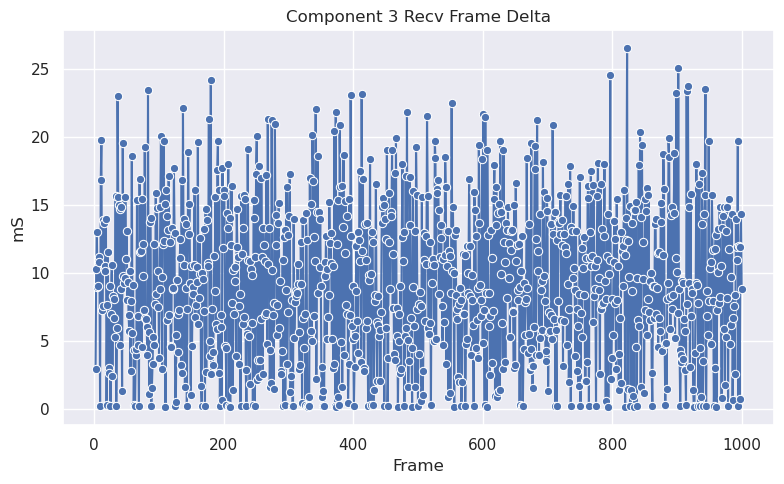

Component 4 Recv Delta Statistics:
count: 999.000
mean: 9.196
std: 6.701
skew: 0.457
kurtosis: -0.485


<Figure size 800x500 with 0 Axes>

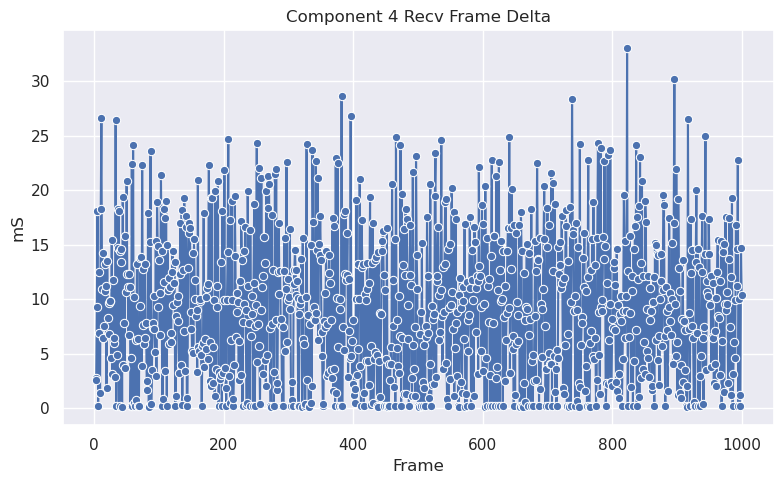

Component 5 Recv Delta Statistics:
count: 999.000
mean: 9.164
std: 7.110
skew: 0.554
kurtosis: -0.365


<Figure size 800x500 with 0 Axes>

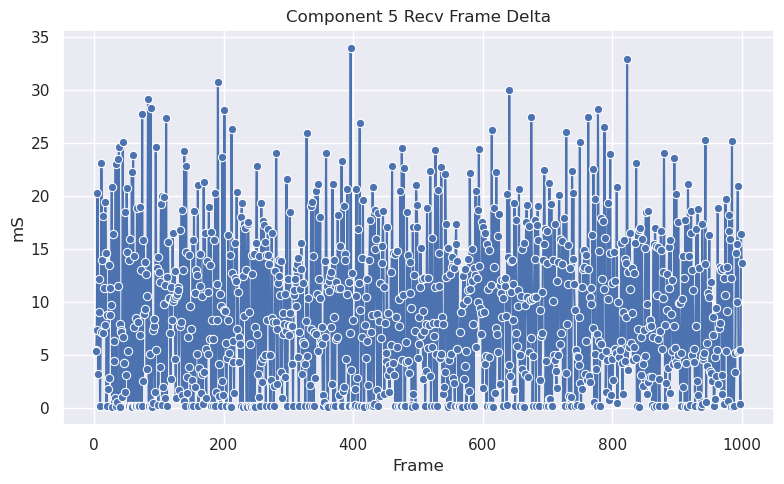

Component 6 Recv Delta Statistics:
count: 999.000
mean: 9.373
std: 7.752
skew: 0.652
kurtosis: -0.235


<Figure size 800x500 with 0 Axes>

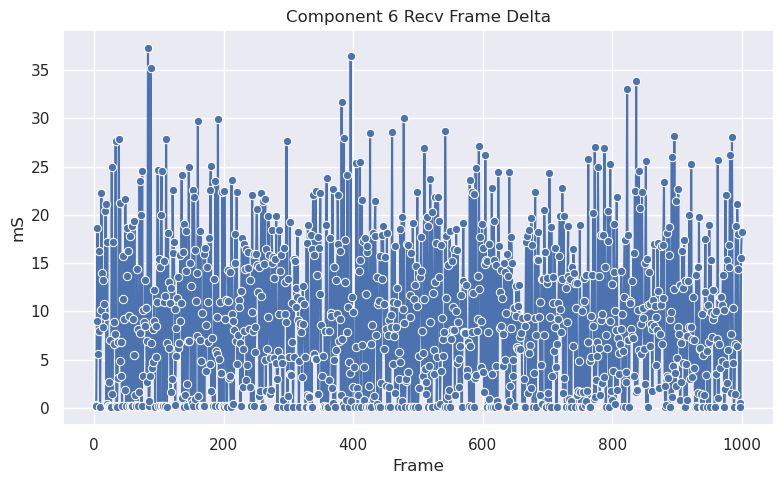

Component 7 Recv Delta Statistics:
count: 999.000
mean: 9.105
std: 7.932
skew: 0.760
kurtosis: -0.158


<Figure size 800x500 with 0 Axes>

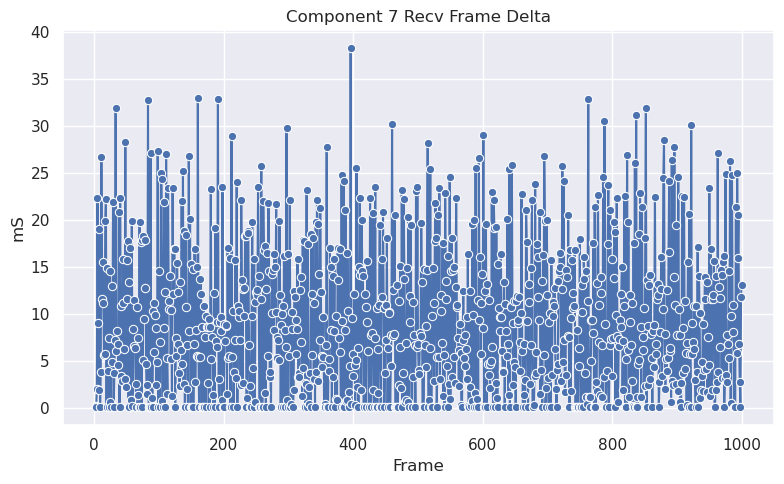

In [26]:
# for drop frames tracking - time delta between new recvd and last done (drop if negative)
# OK in your above data frame, i need to calculate all algebraic differences between the columns 'rcd_uS' - 'done_uS' such that the value of 'done_uS' 
# is obtained from the row previous to that of 'rcd_uS' unless the value of 'done_uS' in the same row as 'rcd_uS' is NaN in which case that row is skipped.  
# Under these conditions the next row will find the value of the previous rows value of 'done_uS' will be NaN and so the next more previous values 
# of 'done_uS' should be used to find the most recent non-NaN value for 'done_uS'.
# The first row for each component should be omitted from processing

for index, cmpnt_id in enumerate(cmpnt_ids):

    plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # sns.lineplot(x=df.loc[df["component"] == i, "frm_nm"][1:], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers

    rcd_uS =  prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1,  "rcd_uS"][1:].reset_index(drop=True)
    done_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "done_uS"][:-1].reset_index(drop=True)

    # print(i)
    # print(rcd)
    # print(done)

    delta_mS = u_m*(rcd_uS - done_uS)

    # Display statistics
    delta_stats_mS = compute_moments(delta_mS)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in delta_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # print(diff)
    # print(df.loc[df["component"] == i, "frm_nm"][1:])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"][1:].reset_index(drop=True), y=delta_mS , marker="o")       # line + markers
    plt.title(f"Component {index+1} Recv Frame Delta")
    plt.xlabel("Frame")
    plt.ylabel("mS")
    plt.tight_layout()
    plt.show()



Component 1 Recv Delta Statistics:
count: 999.000
mean: 15.078
std: 1.999
skew: 0.279
kurtosis: -0.221


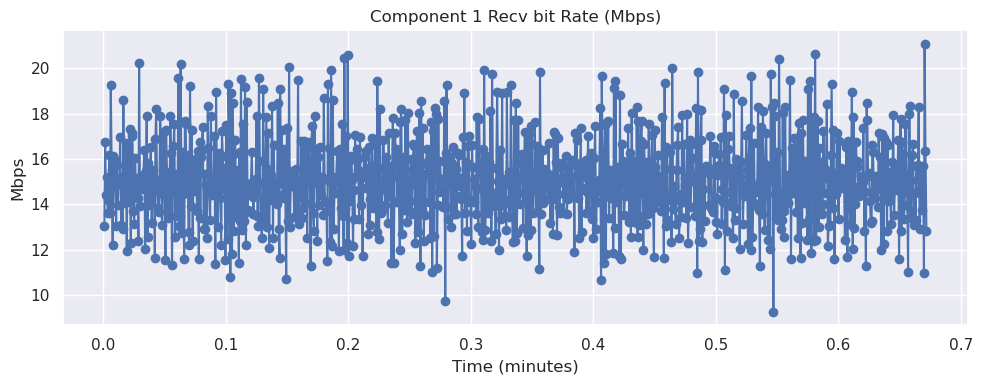

Component 2 Recv Delta Statistics:
count: 999.000
mean: 15.368
std: 1.991
skew: 0.321
kurtosis: 0.133


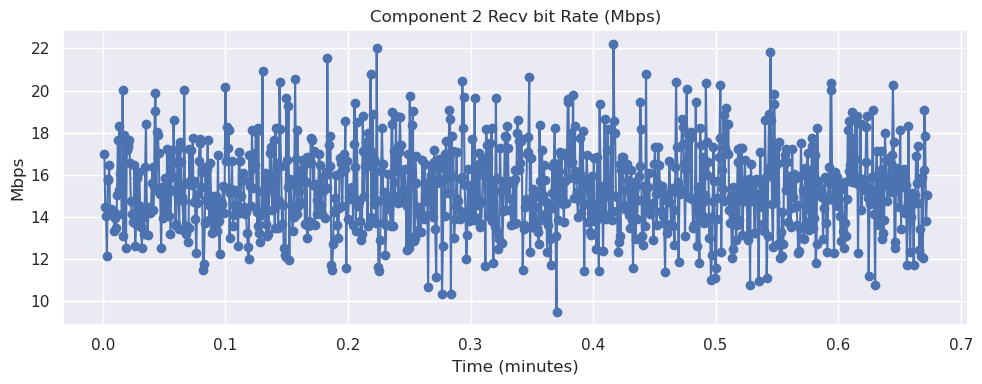

Component 3 Recv Delta Statistics:
count: 999.000
mean: 15.472
std: 2.527
skew: 0.465
kurtosis: 0.184


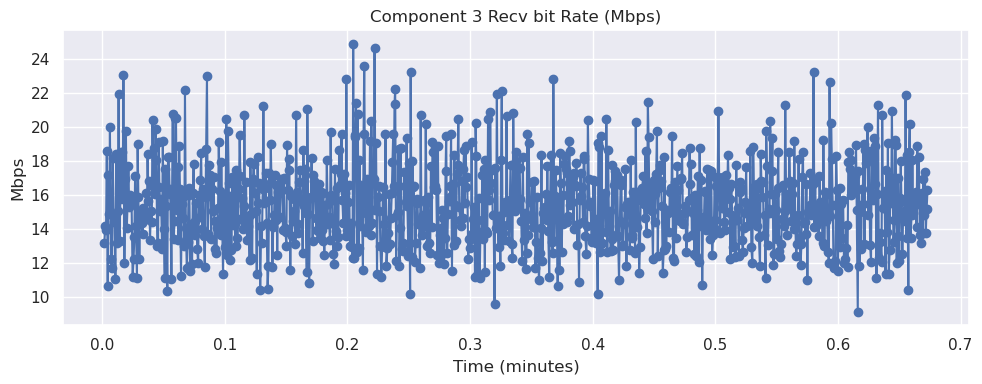

Component 4 Recv Delta Statistics:
count: 999.000
mean: 15.593
std: 2.801
skew: 0.357
kurtosis: -0.164


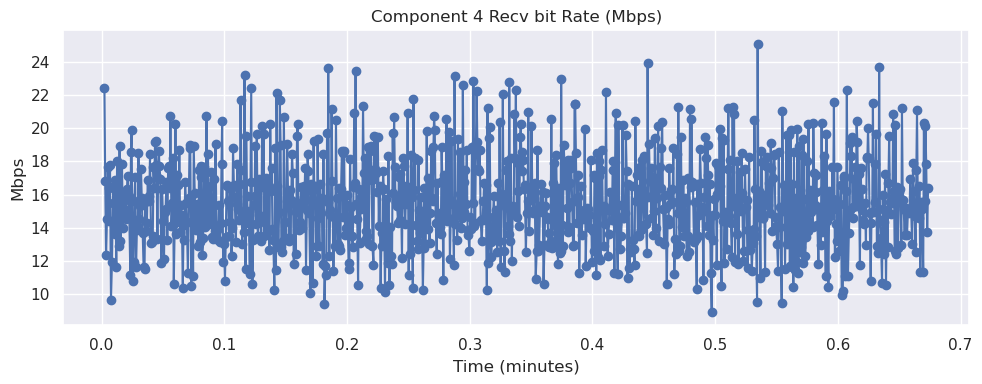

Component 5 Recv Delta Statistics:
count: 999.000
mean: 15.652
std: 2.962
skew: 0.333
kurtosis: -0.318


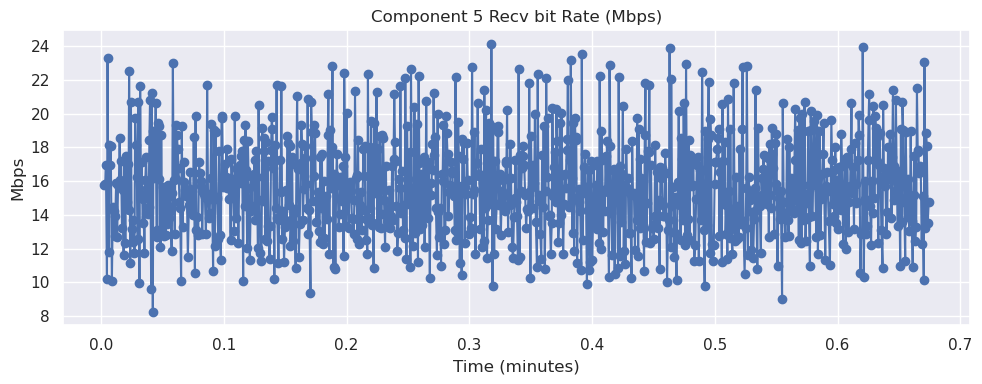

Component 6 Recv Delta Statistics:
count: 999.000
mean: 15.616
std: 3.111
skew: 0.264
kurtosis: -0.435


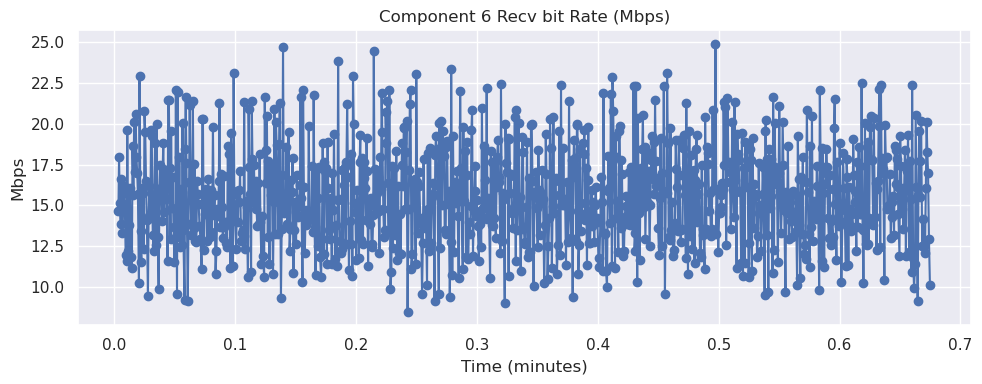

Component 7 Recv Delta Statistics:
count: 999.000
mean: 15.798
std: 3.141
skew: 0.169
kurtosis: -0.501


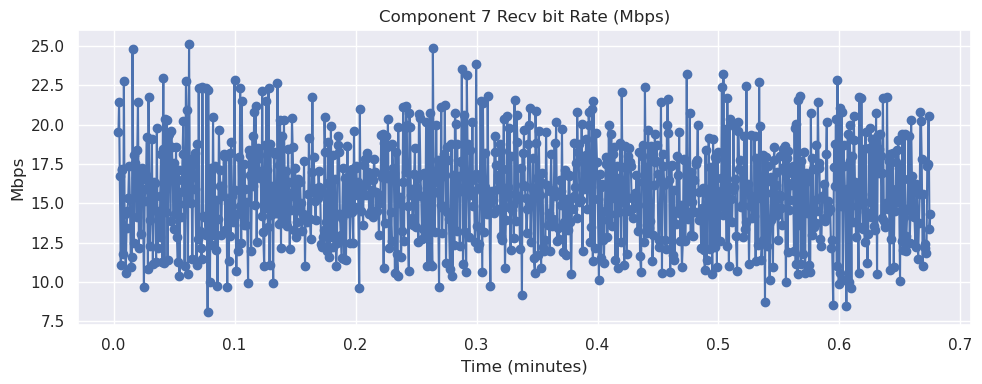

In [27]:
for index, cmpnt_id in enumerate(cmpnt_ids):

    sim_tm_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][1:].reset_index(drop=True) - prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"][:-1].reset_index(drop=True))
    szs_b = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Recv bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 1000.000
mean: 30.580
std: 2.904
skew: 0.011
kurtosis: -0.277


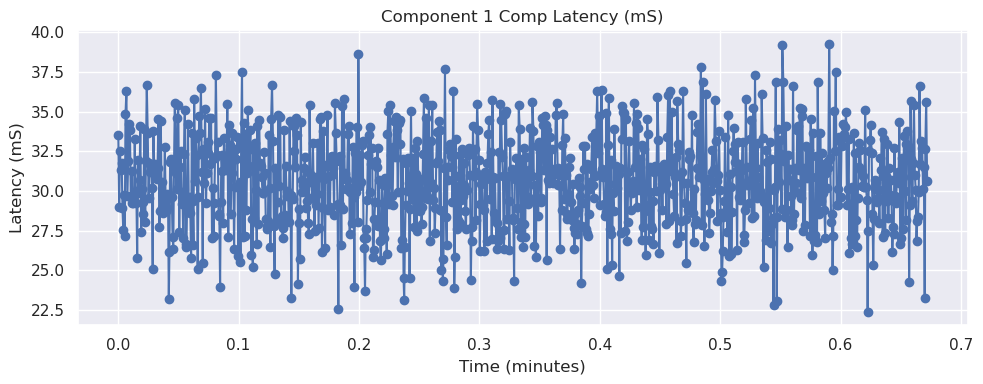

Component 2 Recv Delta Statistics:
count: 1000.000
mean: 31.239
std: 3.146
skew: -0.034
kurtosis: -0.070


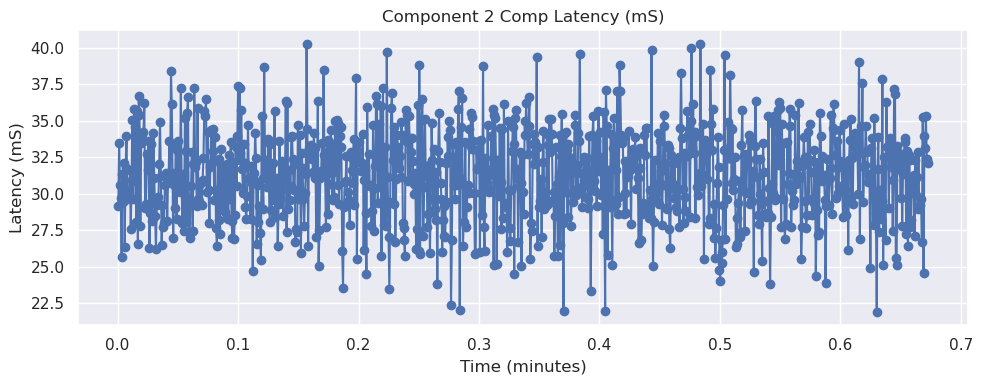

Component 3 Recv Delta Statistics:
count: 1000.000
mean: 31.118
std: 3.077
skew: 0.110
kurtosis: -0.084


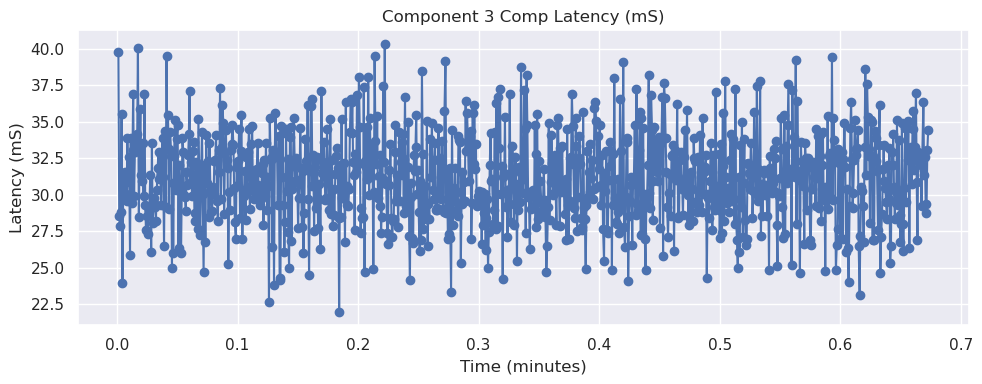

Component 4 Recv Delta Statistics:
count: 1000.000
mean: 31.152
std: 3.050
skew: -0.163
kurtosis: -0.065


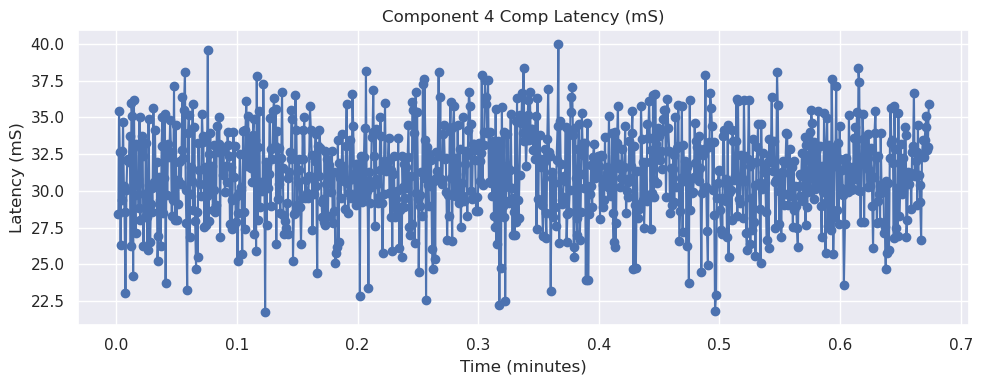

Component 5 Recv Delta Statistics:
count: 1000.000
mean: 31.189
std: 3.058
skew: 0.030
kurtosis: -0.203


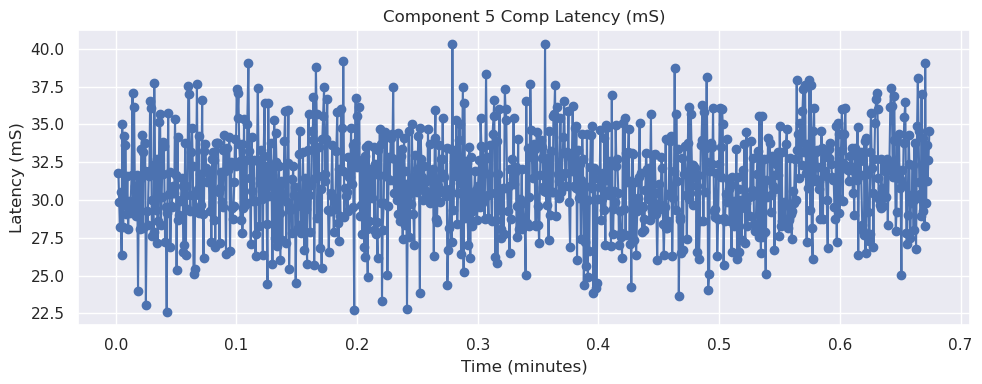

Component 6 Recv Delta Statistics:
count: 1000.000
mean: 30.973
std: 3.171
skew: 0.010
kurtosis: -0.103


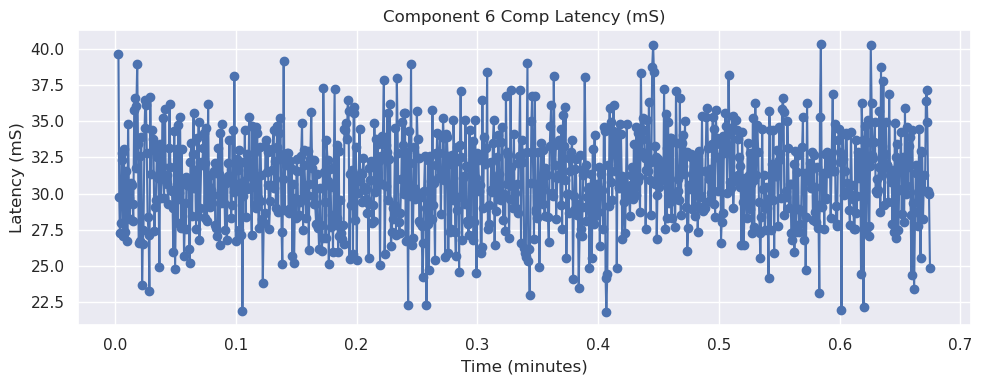

Component 7 Recv Delta Statistics:
count: 1000.000
mean: 31.231
std: 2.953
skew: -0.003
kurtosis: -0.060


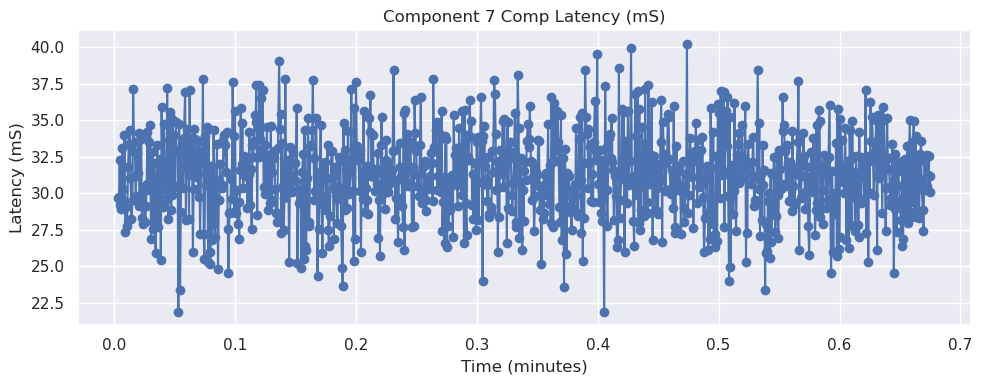

In [28]:
for index, cmpnt_id in enumerate(cmpnt_ids):

    cmpLt_mS = u_m*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "cmp_ltnc_uS"]
    # Display statistics
    cmpLt_stats_mS = compute_moments(cmpLt_mS)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in cmpLt_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, cmpLt_mS, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Comp Latency (mS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (mS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 1000.000
mean: 5.537
std: 0.646
skew: 0.063
kurtosis: -0.255


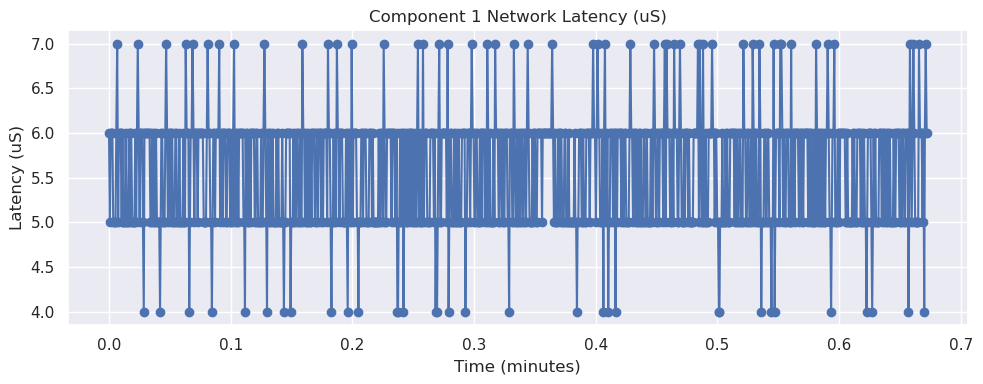

Component 2 Recv Delta Statistics:
count: 1000.000
mean: 5.655
std: 0.670
skew: -0.068
kurtosis: -0.185


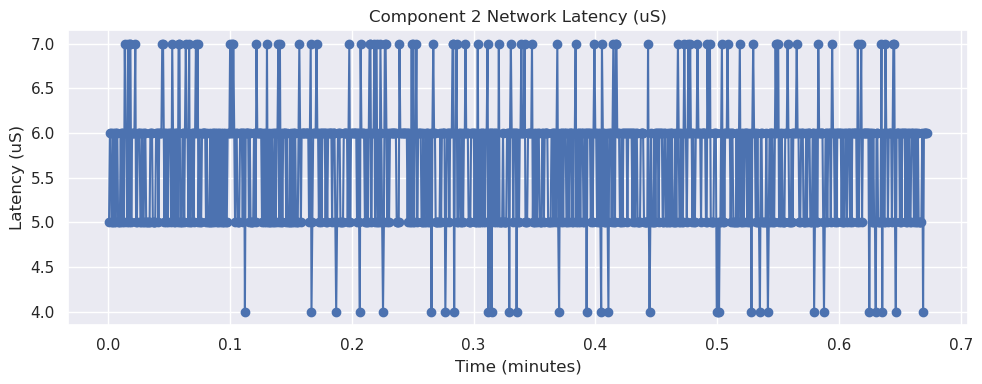

Component 3 Recv Delta Statistics:
count: 1000.000
mean: 5.619
std: 0.681
skew: 0.002
kurtosis: -0.245


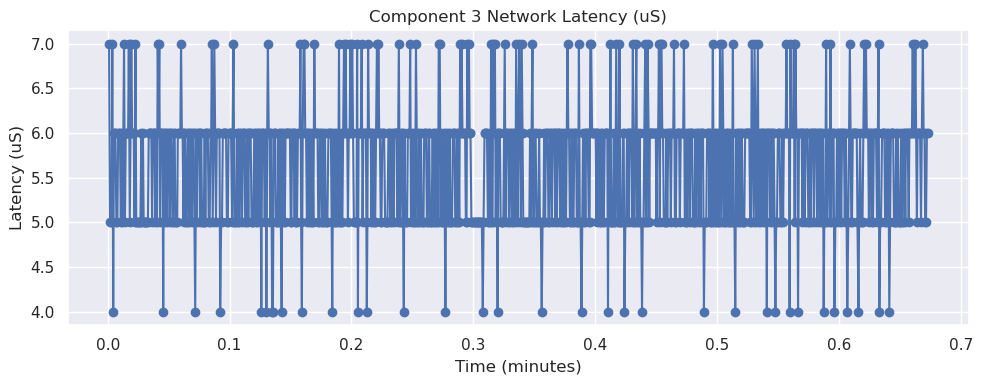

Component 4 Recv Delta Statistics:
count: 1000.000
mean: 5.652
std: 0.682
skew: -0.058
kurtosis: -0.206


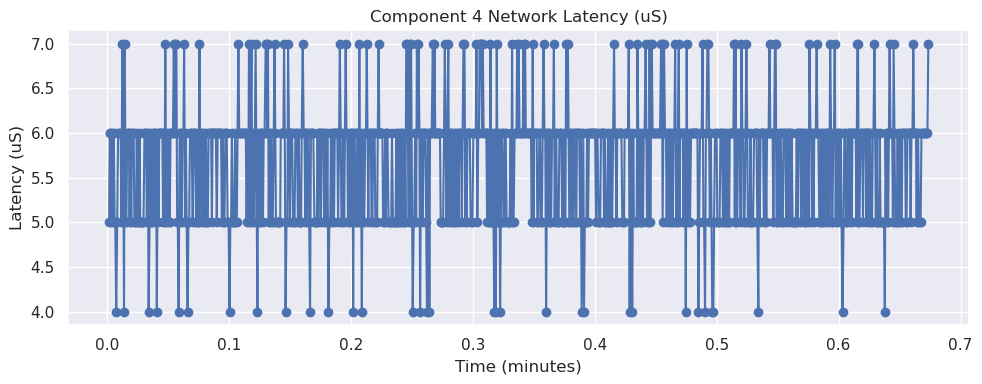

Component 5 Recv Delta Statistics:
count: 1000.000
mean: 5.650
std: 0.687
skew: 0.062
kurtosis: -0.317


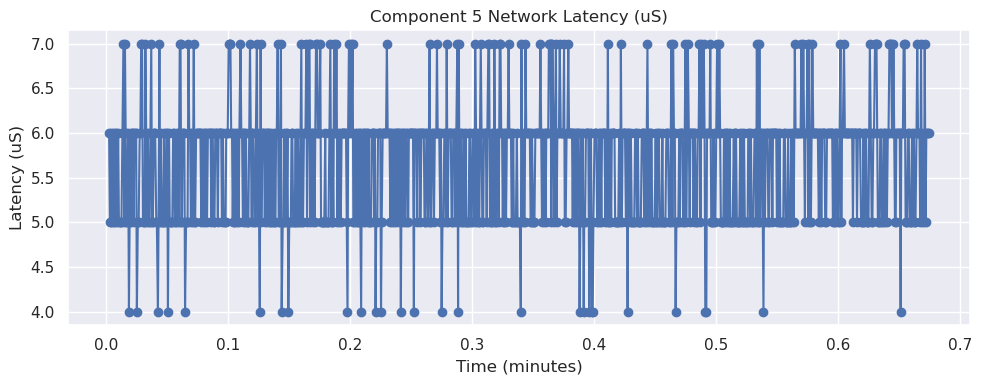

Component 6 Recv Delta Statistics:
count: 1000.000
mean: 5.613
std: 0.679
skew: -0.011
kurtosis: -0.233


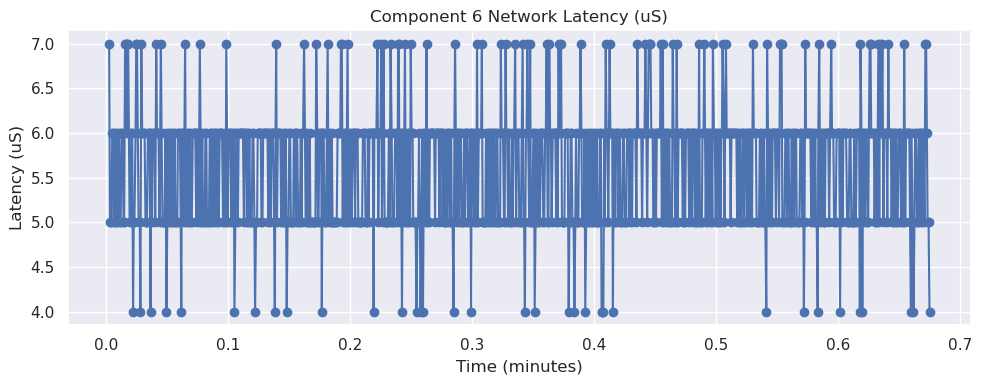

Component 7 Recv Delta Statistics:
count: 1000.000
mean: 5.681
std: 0.659
skew: -0.035
kurtosis: -0.211


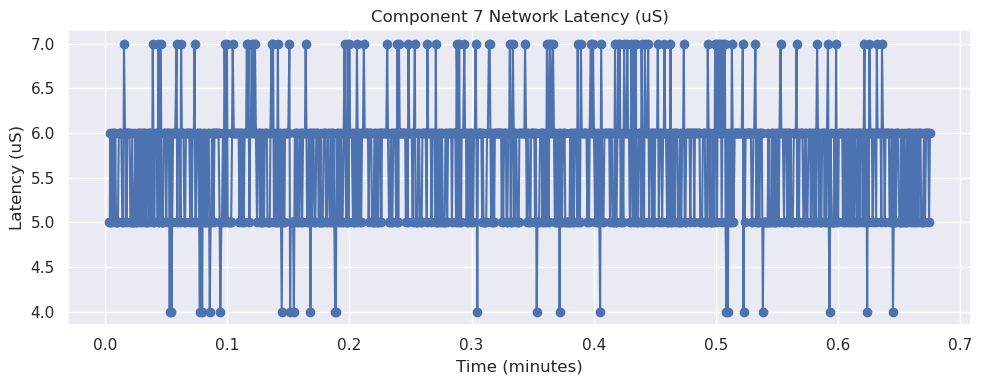

In [29]:
for index, cmpnt_id in enumerate(cmpnt_ids):

    ntwrkLt_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "ntwrk_lt_uS"]
    # Display statistics
    ntwrkLt_stats_uS = compute_moments(ntwrkLt_uS)

    print(f"Component {index+1} Recv Delta Statistics:")
    for k, v in ntwrkLt_stats_uS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, ntwrkLt_uS, marker='o', linestyle='-')
    plt.title(f"Component {index+1} Network Latency (uS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (uS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

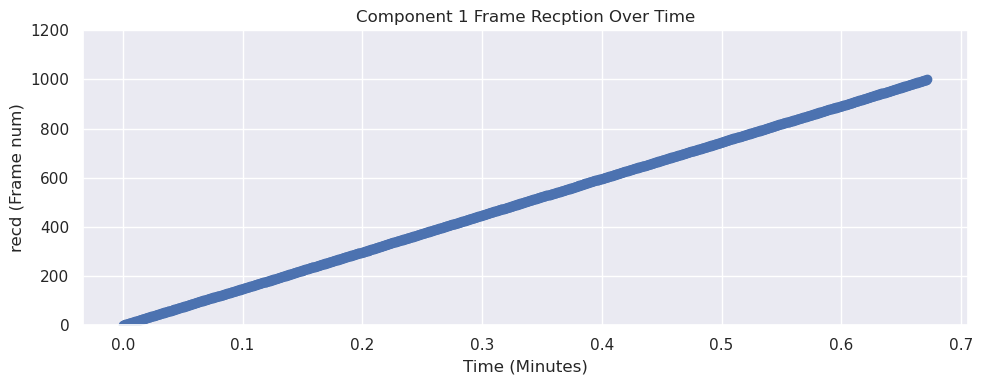

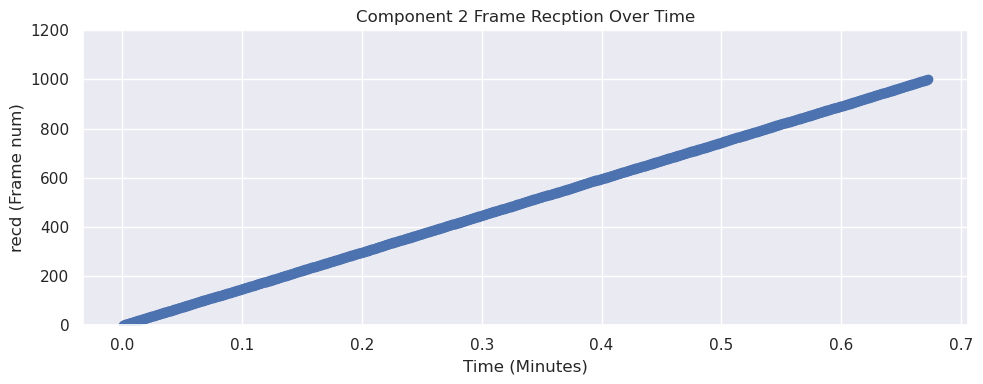

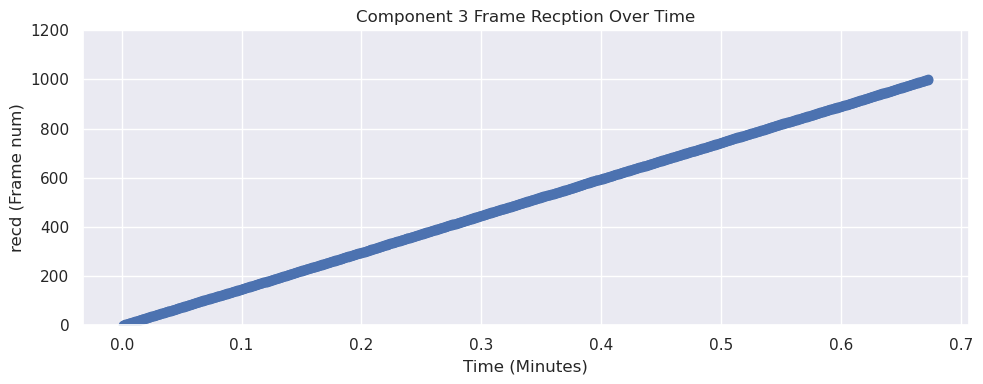

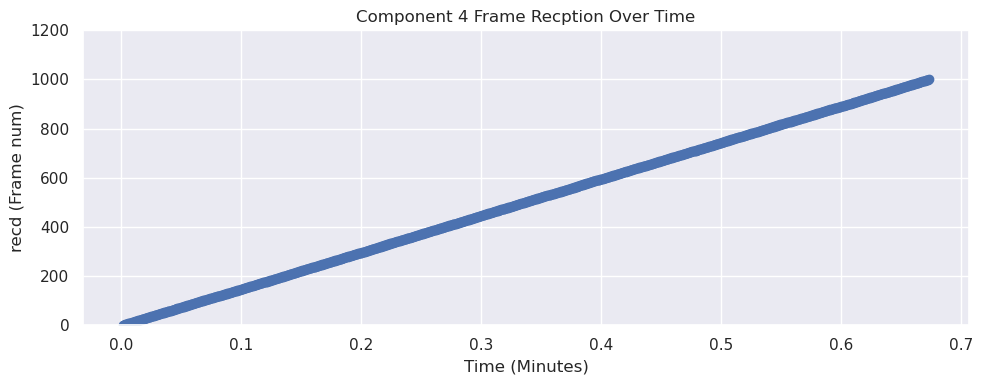

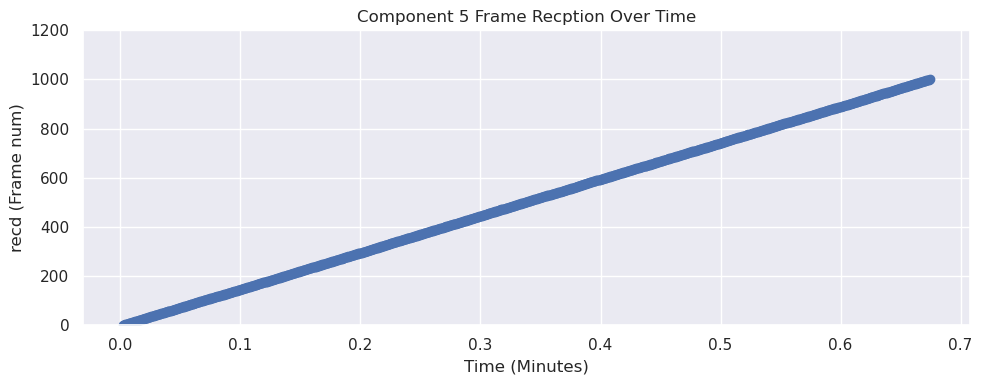

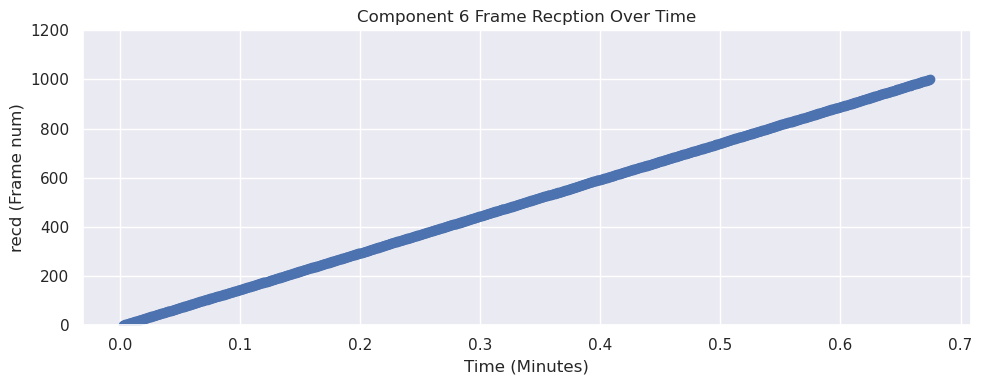

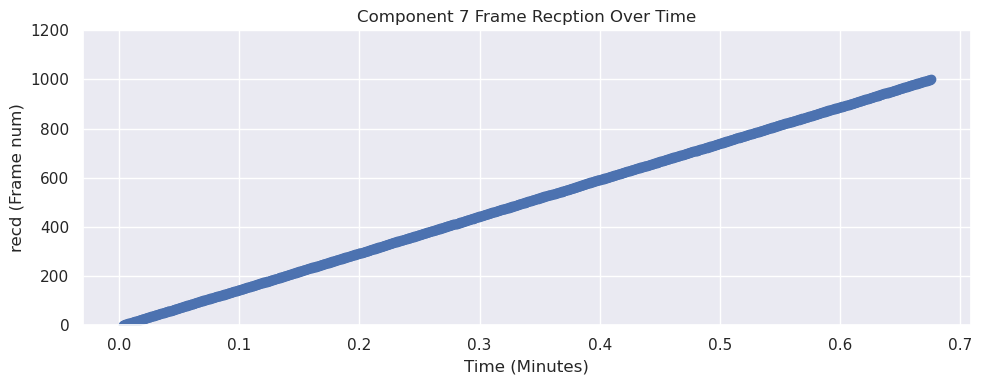

In [30]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"], marker='o', linestyle='-')
    plt.title(f"Component {index+1} Frame Recption Over Time")
    plt.xlabel('Time (Minutes)')
    plt.ylabel('recd (Frame num)')
    plt.ylim(0, max(prcsdFrms_df['frm_nm']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/scratch/slurm/53026789/.cache/tmp/ipykernel_1938458/1367276164.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


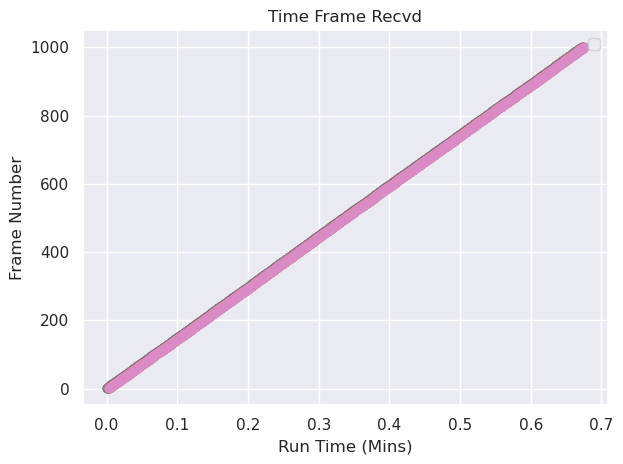

In [31]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (Mins)')
plt.ylabel('Frame Number')
plt.title('Time Frame Recvd')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


/scratch/slurm/53026789/.cache/tmp/ipykernel_1938458/4157545793.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


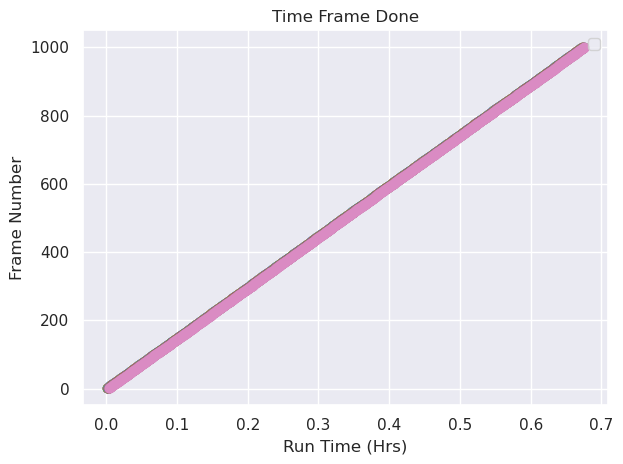

In [32]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "done_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == index+1, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (Hrs)')
plt.ylabel('Frame Number')
plt.title('Time Frame Done')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
drpmsdFrms_df.head(5)

Empty DataFrame
Columns: [component, rcd_uS, frm_nm, frm_sz_b, lstDone_uS]
Index: []

In [34]:
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
for c in cmpnt_drp_nms:
    print(f"Number of drops for component {c}: {len(drp_sets_by_component[c])}")

In [35]:
drp_sets_by_component

Series([], Name: frm_nm, dtype: int64)

In [36]:
cmpnt_drp_nms

set()

In [37]:
prcsd_frm_sets_by_component = prcsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_frn_nms = set(prcsdFrms_df["component"].unique())
for c in cmpnt_frn_nms:
    print(f"Number of processed frames for component {c}: {len(prcsd_frm_sets_by_component[c])}")

Number of processed frames for component 1: 1000
Number of processed frames for component 2: 1000
Number of processed frames for component 3: 1000
Number of processed frames for component 4: 1000
Number of processed frames for component 5: 1000
Number of processed frames for component 6: 1000
Number of processed frames for component 7: 1000


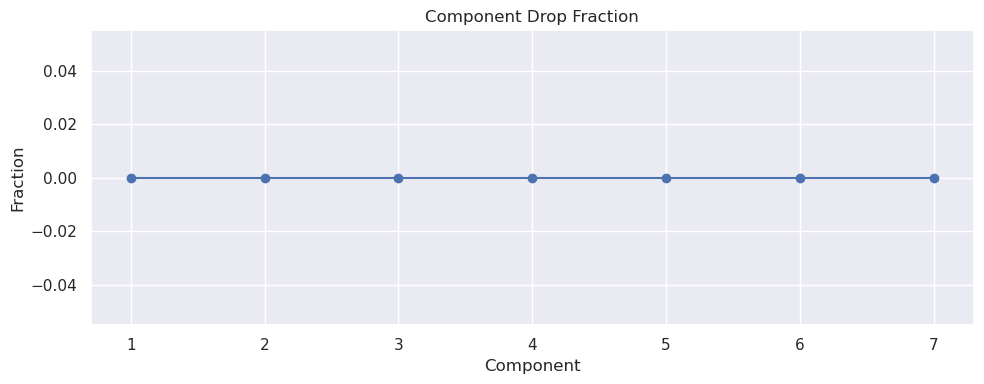

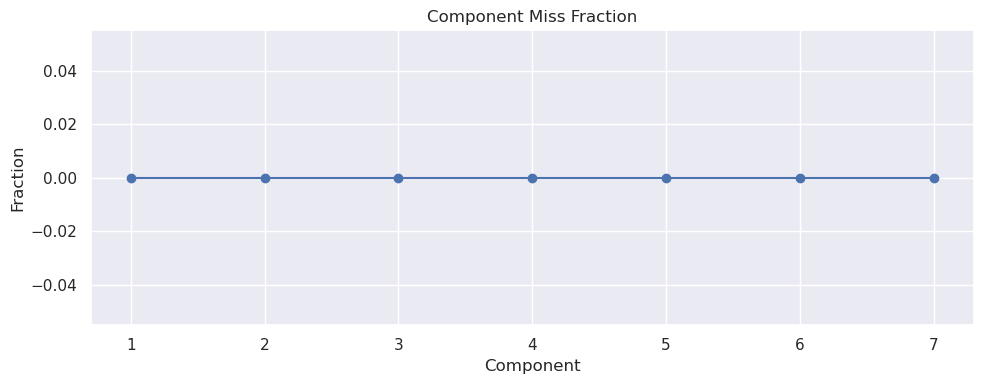

In [38]:
cmpnt_cnt = len(cmpnt_ids)
drpdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "drp_frctn":   pd.Series(dtype=int)
})

cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
#dataframe record for components with no drops
# for index, cmpnt_id in enumerate(cmpnt_ids):
for c in set(range(1,cmpnt_cnt+1)) - cmpnt_drp_nms: #the set of compnents with no drops
    row = (c,0)
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)
    
#dataframe record for components with drops
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
# for index, cmpnt_id in enumerate(cmpnt_ids):
for c in cmpnt_drp_nms:
    row = (c,len(drp_sets_by_component[c])/(len(drp_sets_by_component[c]) + len(prcsd_frm_sets_by_component[c])))
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)

# drpdFrmsFrctn_df

# Plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

x = drpdFrmsFrctn_df['component'].astype(int)
y = drpdFrmsFrctn_df['drp_frctn']
max_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Drop Fraction")
ax.set_xlabel("Component")
ax.set_ylabel("Fraction")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()

#Frames that components missed because they were never received
msdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "msd_frctn": pd.Series(dtype=int)
})

#Compnents miss frames when upstream senders do not send
#Upstrean components do not send frames they miss or drop
#The effect is cummulative for downstream components

#For each component, This equates to the number of sender frames - (number processd + the number droped (since they were not missed))

# for index, cmpnt_id in enumerate(cmpnt_ids):
#     row = (int(index+1),1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == int(index+1), "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == int(index+1), "frm_nm"])))/len(all_frm_set))
#     msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

#The first component never misses frames
row = (1,0)
msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

for c in range(2,cmpnt_cnt+1):
    row = (c,1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == c-1, "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c-1, "frm_nm"])))/len(all_frm_set))
    msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

x = msdFrmsFrctn_df['component'].astype(int)
y = msdFrmsFrctn_df['msd_frctn']
ax_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Miss Fraction")
ax.set_xlabel("Component")
ax.set_ylabel("Fraction")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()


In [39]:
len(all_frm_set)

1000

In [40]:
c=2

In [41]:
len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == c-1, "frm_nm"]))

1000

In [42]:
len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c-1, "frm_nm"]))

0

In [43]:
print(c,1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == c-1, "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c-1, "frm_nm"])))/len(all_frm_set))


2 0.0


In [44]:
cmpnt_cnt = len(cmpnt_ids)

In [45]:
cmpnt_cnt

7

In [46]:
cmpnt_drp_nms

set()

In [47]:
set(range(1,cmpnt_cnt+1)) - cmpnt_drp_nms

{1, 2, 3, 4, 5, 6, 7}

In [48]:
# for c in range(1,cmpnt_cnt+1):
#     print(len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c, "frm_nm"])))

In [49]:
prcsdFrms_df.loc[prcsdFrms_df["component"] == 1, "frm_nm"]

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: frm_nm, Length: 1000, dtype: int64

In [50]:
frame_cnt = 1000

In [51]:
#misses
set(range(1,frame_cnt)) - set(prcsdFrms_df.loc[prcsdFrms_df["component"] == 1, "frm_nm"])

set()

In [52]:
#misses
set(range(1,frame_cnt)) - set(prcsdFrms_df.loc[prcsdFrms_df["component"] == 2, "frm_nm"])

set()

In [53]:
cmpnt_cnt# set(prcsdFrms_df.loc[prcsdFrms_df["component"] == 1, "frm_nm"])

7

In [54]:
# set(range(1,frame_cnt))

In [55]:
drpmsdFrms_df

Empty DataFrame
Columns: [component, rcd_uS, frm_nm, frm_sz_b, lstDone_uS]
Index: []

In [56]:
drpdFrmsFrctn_df

component  drp_frctn
0          1          0
1          2          0
2          3          0
3          4          0
4          5          0
5          6          0
6          7          0

In [57]:
drp_sets_by_component

Series([], Name: frm_nm, dtype: int64)

In [58]:
frame_cnt

1000

In [59]:
78/frame_cnt

0.078